# Lotka-Volterra Model

In [1]:
using AlgebraicPetri

using Petri: Model, Graph
using OrdinaryDiffEq
using Plots

using Catlab
using Catlab.Theories
using Catlab.Programs
using Catlab.CategoricalAlgebra.FreeDiagrams
using Catlab.WiringDiagrams
using Catlab.Graphics

display_wd(ex) = to_graphviz(ex, orientation=LeftToRight, labels=true);

#### Step 1: Define the building block Petri nets needed to construct the model

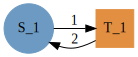

In [2]:
petriOb = codom(Open([1], PetriNet(1), [1]))
birth_petri = Open([1], PetriNet(1, (1, (1,1))), [1]);
Graph(Model(apex(birth_petri)))

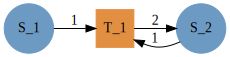

In [3]:
predation_petri = Open([1,2], PetriNet(2, ((1,2), (2,2))), [2]);
Graph(Model(apex(predation_petri)))

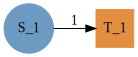

In [4]:
death_petri = Open([1], PetriNet(1, (1, ())), [1]);
Graph(Model(apex(death_petri)))

#### Step 2: Define a presentation of the free biproduct category
that encodes the domain specific information

In [5]:
@present Predation(FreeBiproductCategory) begin
    prey::Ob
    predator::Ob
    birth::Hom(prey,prey)
    predation::Hom(prey⊗predator,predator)
    death::Hom(predator,predator)
end;

rabbits,wolves,birth,predation,death = generators(Predation);

F(ex) = functor((OpenPetriNetOb, OpenPetriNet), ex, generators=Dict(
                 rabbits=>petriOb,wolves=>petriOb,
                 birth=>birth_petri, predation=>predation_petri, death=>death_petri));

#### Step 3: Generate models using the hom expression or program notations

┌ Warning: `find_root` is deprecated, use `find_root!` instead.
│   caller = #30 at none:0 [inlined]
└ @ Core ./none:0
┌ Warning: `find_root` is deprecated, use `find_root!` instead.
│   caller = #30 at none:0 [inlined]
└ @ Core ./none:0


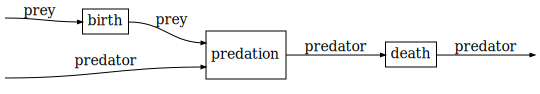

In [6]:
lotka_volterra = (birth ⊗ id(wolves)) ⋅ predation ⋅ death
lotka_petri = apex(F(lotka_volterra))
display_wd(lotka_volterra)

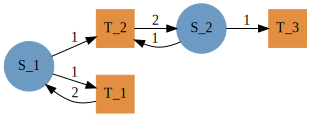

In [7]:
Graph(Model(lotka_petri))

Generate appropriate vector fields, define parameters, and visualize solution

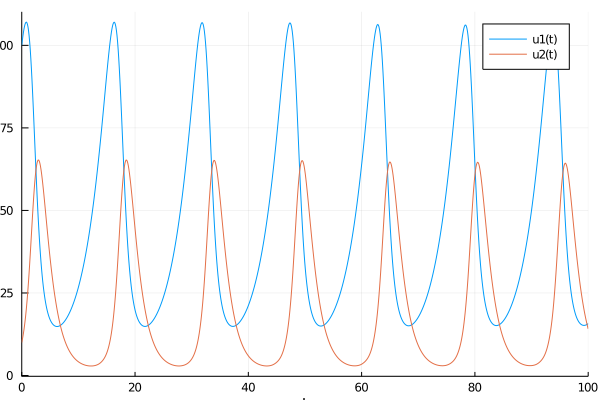

In [8]:
u0 = [100, 10];
p = [.3, .015, .7];
prob = ODEProblem(vectorfield(lotka_petri),u0,(0.0,100.0),p);
sol = solve(prob,Tsit5(),abstol=1e-8);
plot(sol)

There is also a second syntax that is easier to write for programmers
than the hom expression syntax. Here is an example of the same model
as before along with a test of equivalency

In [9]:
lotka_volterra2 = @program Predation (r::prey, w::predator) begin
  r_2 = birth(r)
  w_2 = predation(r_2, w)
  return death(w_2)
end
lotka_petri2 = apex(F(to_hom_expr(FreeBiproductCategory, lotka_volterra2)))
lotka_petri == lotka_petri2

┌ Warning: `find_root` is deprecated, use `find_root!` instead.
│   caller = #30 at none:0 [inlined]
└ @ Core ./none:0
┌ Warning: `find_root` is deprecated, use `find_root!` instead.
│   caller = #30 at none:0 [inlined]
└ @ Core ./none:0


true

#### Step 4: Extend your presentation to handle more complex phenomena
such as a small food chain

In [10]:
@present DualPredation <: Predation begin
    Predator::Ob
    Predation::Hom(predator⊗Predator,Predator)
    Death::Hom(Predator,Predator)
end;

fish,Fish,Shark,birth,predation,death,Predation,Death = generators(DualPredation);

F(ex) = functor((OpenPetriNetOb, OpenPetriNet), ex, generators=Dict(
                 fish=>petriOb,Fish=>petriOb,
                 birth=>birth_petri, predation=>predation_petri, death=>death_petri,
                 Shark=>petriOb,Predation=>predation_petri, Death=>death_petri));

Define a new model where fish are eaten by Fish which are then eaten by Sharks

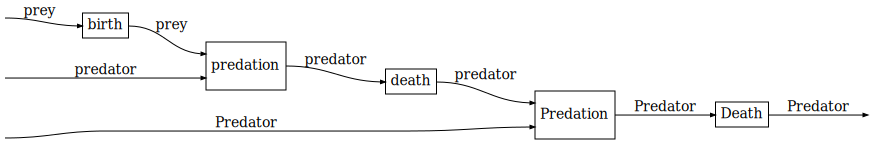

In [11]:
dual_lv = @program DualPredation (fish::prey, Fish::predator, Shark::Predator) begin
  f_2 = birth(fish)
  F_2 = predation(f_2, Fish)
  F_3 = death(F_2)
  S_2 = Predation(F_3, Shark)
  S_3 = Death(S_2)
end
display_wd(dual_lv)

┌ Warning: `find_root` is deprecated, use `find_root!` instead.
│   caller = #30 at none:0 [inlined]
└ @ Core ./none:0
┌ Warning: `find_root` is deprecated, use `find_root!` instead.
│   caller = #30 at none:0 [inlined]
└ @ Core ./none:0


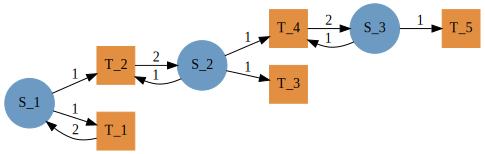

In [12]:
dual_lv_petri = apex(F(to_hom_expr(FreeBiproductCategory, dual_lv)))
Graph(Model(dual_lv_petri))

Generate a new solver, provide parameters, and analyze results

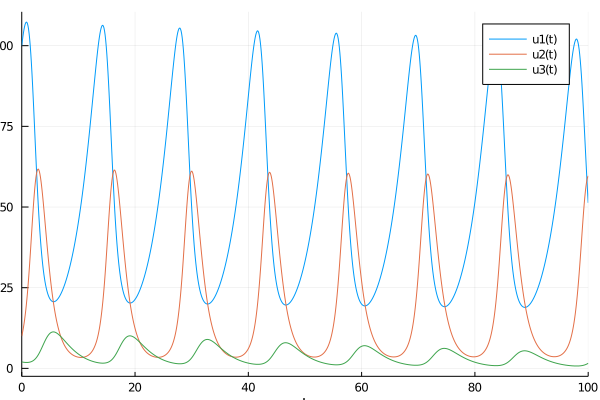

In [13]:
u0 = [100, 10, 2];
p = [.3, .015, .7, .017, .35];
prob = ODEProblem(vectorfield(dual_lv_petri),u0,(0.0,100.0),p);
sol = solve(prob,Tsit5(),abstol=1e-6);
plot(sol)